<a href="https://colab.research.google.com/github/weso500/QMLIIOT/blob/main/QuantumOttowaRuns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.3/418.3 kB 10.0 MB/s eta 0:00:00


In [2]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import zipfile
import pandas as pd

In [3]:
# Path to your ZIP file
zip_path = '/content/drive/MyDrive/FDA Journal/University of Ottawa Rolling-element Dataset – Vibration and Acoustic Faults under Constant Load and Speed conditions (UORED-VAFCLS).zip'

# Create a dictionary to store DataFrames
dataframes = {}

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    # Loop through each file in the ZIP
    for filename in z.namelist():
        if filename.endswith('.csv'):
            # Read each CSV into a DataFrame
            with z.open(filename) as f:
                df = pd.read_csv(f)
                dataframes[filename] = df

# Create an empty list to store healthy dataframes
healthy_dfs = []

# Iterate through the dataframes dictionary
for filename, df in dataframes.items():
    # Check if 'Healthy' is in the filename
    if 'Healthy' in filename:
        healthy_dfs.append(df)

# Concatenate the healthy dataframes into a single dataframe
healthy_merged_df = pd.concat(healthy_dfs, ignore_index=True)


from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to normalize
columns_to_normalize = ['Accelerometer', 'Acoustic', 'Temperature Difference']

# Fit and transform the selected columns
healthy_merged_df[columns_to_normalize] = scaler.fit_transform(healthy_merged_df[columns_to_normalize])

# Drop the 'Speed' and 'Load' columns
healthy_merged_df = healthy_merged_df.drop(['Speed', 'Load'], axis=1)

# Display the first few rows of the modified dataframe
display(healthy_merged_df.head())


,Accelerometer,Acoustic,Temperature Difference
0,0.481013,0.053183,0.544363
1,0.468693,0.053487,0.539877
2,0.466744,0.053639,0.551189
3,0.463469,0.053791,0.539894
4,0.462299,0.054247,0.535373


In [4]:
def create_windows(df, window_size, overlap):
    windows = []
    step_size = window_size
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        windows.append(window)
    return windows

window_size = 4200
overlap = int(window_size * 0.5)

healthy_windows = create_windows(healthy_merged_df, window_size, overlap)

# Create empty dictionaries to store data for each sensor
sensor_data = {
    'Accelerometer': [],
    'Acoustic': [],
    'Temperature Difference': []
}

# Iterate through each window
for window in healthy_windows:
    # Extract data for each sensor and append to the respective list
    sensor_data['Accelerometer'].append(window['Accelerometer'].values)
    sensor_data['Acoustic'].append(window['Acoustic'].values)
    sensor_data['Temperature Difference'].append(window['Temperature Difference'].values)

# Convert the lists of arrays into dataframes
accelerometer_df = pd.DataFrame(sensor_data['Accelerometer'])
acoustic_df = pd.DataFrame(sensor_data['Acoustic'])
temperature_df = pd.DataFrame(sensor_data['Temperature Difference'])

# Display the shapes of the new dataframes to confirm
print(f"Shape of Accelerometer dataframe: {accelerometer_df.shape}")
print(f"Shape of Acoustic dataframe: {acoustic_df.shape}")
print(f"Shape of Temperature Difference dataframe: {temperature_df.shape}")

Shape of Accelerometer dataframe: (2000, 4200)
Shape of Acoustic dataframe: (2000, 4200)
Shape of Temperature Difference dataframe: (2000, 4200)


In [5]:
# Path to your ZIP file
zip_path = '/content/drive/MyDrive/FDA Journal/University of Ottawa Rolling-element Dataset – Vibration and Acoustic Faults under Constant Load and Speed conditions (UORED-VAFCLS).zip'

# Create a dictionary to store DataFrames
fault_dataframes = {}

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    # Loop through each file in the ZIP
    for filename in z.namelist():
        if filename.endswith('.csv') and 'Fault' in filename:
            # Read each CSV into a DataFrame
            with z.open(filename) as f:
                df = pd.read_csv(f)
                fault_dataframes[filename] = df

# Create empty lists to store dataframes for developing and faulty conditions
fault_developing_dfs = []
faulty_dfs = []

# Iterate through the fault_dataframes dictionary
for filename, df in fault_dataframes.items():
    # Extract the fault condition from the filename using the labeling scheme
    # Assuming the format is Type_Bearing_Condition.csv (e.g., I_1_1.csv)
    parts = filename.split('/')[-1].split('.')[0].split('_')
    if len(parts) >= 3:
        condition = parts[2]
        if condition == '1':
            fault_developing_dfs.append(df)
        elif condition == '2':
            faulty_dfs.append(df)

# Concatenate the dataframes for each condition
fault_developing_merged_df = pd.concat(fault_developing_dfs, ignore_index=True)
faulty_merged_df = pd.concat(faulty_dfs, ignore_index=True)

# Display the first few rows of the merged dataframes
print("Fault Developing Merged DataFrame:")
display(fault_developing_merged_df.head())

print("\nFaulty Merged DataFrame:")
display(faulty_merged_df.head())

# Select the columns to normalize for fault dataframes
columns_to_normalize_fault = ['Accelerometer', 'Acoustic', 'Temperature Difference']

# Apply the scaler (fitted on healthy data) to the fault dataframes
fault_developing_merged_df[columns_to_normalize_fault] = scaler.transform(fault_developing_merged_df[columns_to_normalize_fault])
faulty_merged_df[columns_to_normalize_fault] = scaler.transform(faulty_merged_df[columns_to_normalize_fault])

# Drop the 'Speed' and 'Load' columns from fault dataframes
fault_developing_merged_df = fault_developing_merged_df.drop(['Speed', 'Load'], axis=1)
faulty_merged_df = faulty_merged_df.drop(['Speed', 'Load'], axis=1)

# Display the first few rows of the modified fault dataframes
print("Fault Developing Merged DataFrame after normalization and dropping columns:")
display(fault_developing_merged_df.head())

print("\nFaulty Merged DataFrame after normalization and dropping columns:")
display(faulty_merged_df.head())


# Apply windowing to the fault developing and faulty dataframes
fault_developing_windows = create_windows(fault_developing_merged_df, window_size, overlap)
faulty_windows = create_windows(faulty_merged_df, window_size, overlap)

# Print the number of windows created for each fault type to confirm
print(f"Number of windows created for fault developing data: {len(fault_developing_windows)}")
print(f"Number of windows created for faulty data: {len(faulty_windows)}")


Fault Developing Merged DataFrame:


,Accelerometer,Acoustic,Speed,Load,Temperature Difference
0,19.700756,0.074370,1819,400,22.575598
1,19.829687,0.083576,0,0,21.964033
2,22.021502,0.088179,0,0,22.583118
3,23.923225,0.088508,0,0,21.308137
4,24.148853,0.092453,0,0,22.106005



Faulty Merged DataFrame:


,Accelerometer,Acoustic,Speed,Load,Temperature Difference
0,34.785607,-0.025905,1819,400,24.261550
1,35.591422,-0.024261,0,0,24.221602
2,37.815471,-0.019987,0,0,25.064400
3,36.784028,-0.018672,0,0,24.425321
4,40.942032,-0.021302,0,0,26.213233


Fault Developing Merged DataFrame after normalization and dropping columns:


,Accelerometer,Acoustic,Temperature Difference
0,0.517894,0.089804,0.803458
1,0.518206,0.094058,0.795036
2,0.523508,0.096186,0.803561
3,0.528108,0.096338,0.786004
4,0.528654,0.098161,0.796991



Faulty Merged DataFrame after normalization and dropping columns:


,Accelerometer,Acoustic,Temperature Difference
0,0.554385,0.043458,0.826674
1,0.556334,0.044218,0.826124
2,0.561715,0.046194,0.837729
3,0.559219,0.046801,0.828929
4,0.569278,0.045586,0.853549


Number of windows created for fault developing data: 2000
Number of windows created for faulty data: 2000


In [6]:
from scipy.stats import kurtosis, skew
from scipy.fft import fft
import numpy as np

def calculate_features(windows, sensor_name):
    features_list = []
    for window in windows:
        # Calculate RMS
        rms = np.sqrt(np.mean(window**2))

        # Calculate Kurtosis and Skewness
        kurt = kurtosis(window)
        sk = skew(window)

        # Calculate FFT and energy bands (example: 4 bands)
        yf = fft(window)
        n = len(window)
        frequencies = np.fft.fftfreq(n)
        # Get the positive frequencies and their corresponding FFT values
        positive_frequencies = frequencies[:n//2]
        positive_yf = np.abs(yf[:n//2])

        # Define frequency bands (adjust as needed based on your data's frequency range)
        # For example, let's divide the positive frequencies into 4 equal bands
        band_width = len(positive_frequencies) // 4
        fft_bands = []
        for i in range(4):
            start = i * band_width
            end = (i + 1) * band_width if i < 3 else len(positive_frequencies)
            band_energy = np.sum(positive_yf[start:end]**2)
            fft_bands.append(band_energy)


        # Calculate Entropy (example: Spectral Entropy)
        # Normalize the power spectrum to get probability distribution
        power_spectrum = positive_yf**2
        total_energy = np.sum(power_spectrum)
        if total_energy > 0:
            probability_distribution = power_spectrum / total_energy
            # Avoid log(0) by replacing zeros with a small epsilon
            epsilon = 1e-10
            probability_distribution[probability_distribution == 0] = epsilon
            entropy = -np.sum(probability_distribution * np.log2(probability_distribution))
        else:
            entropy = 0 # Handle cases with zero total energy

        features = {
            f'{sensor_name}_RMS': rms,
            f'{sensor_name}_Kurtosis': kurt,
            f'{sensor_name}_Skewness': sk,
            f'{sensor_name}_Entropy': entropy
        }
        # Add FFT bands to the features dictionary
        for i, band_energy in enumerate(fft_bands):
            features[f'{sensor_name}_FFT_Band_{i+1}'] = band_energy

        features_list.append(features)

    return pd.DataFrame(features_list)

# Calculate features for each sensor
accelerometer_features_df = calculate_features(sensor_data['Accelerometer'], 'Accelerometer')
acoustic_features_df = calculate_features(sensor_data['Acoustic'], 'Acoustic')
temperature_features_df = calculate_features(sensor_data['Temperature Difference'], 'Temperature')

# Display the first few rows of the new dataframes
print("Accelerometer Features DataFrame:")
display(accelerometer_features_df.head())

print("\nAcoustic Features DataFrame:")
display(acoustic_features_df.head())

print("\nTemperature Features DataFrame:")
display(temperature_features_df.head())

Accelerometer Features DataFrame:


,Accelerometer_RMS,Accelerometer_Kurtosis,Accelerometer_Skewness,Accelerometer_Entropy,Accelerometer_FFT_Band_1,Accelerometer_FFT_Band_2,Accelerometer_FFT_Band_3,Accelerometer_FFT_Band_4
0,0.473201,1.946419,-0.013277,0.002477,3.949451e+06,7.657936,26.869585,8.191180
1,0.473305,1.042136,0.061701,0.002777,3.951131e+06,8.650118,23.278551,8.291966
2,0.473291,0.580422,-0.082945,0.002610,3.950919e+06,9.572151,25.939991,7.903715
3,0.473328,-0.020088,-0.038325,0.002304,3.951599e+06,7.691318,23.073395,10.398373
4,0.473344,0.224499,0.067521,0.002116,3.951908e+06,8.547743,27.991764,9.791571



Acoustic Features DataFrame:


,Acoustic_RMS,Acoustic_Kurtosis,Acoustic_Skewness,Acoustic_Entropy,Acoustic_FFT_Band_1,Acoustic_FFT_Band_2,Acoustic_FFT_Band_3,Acoustic_FFT_Band_4
0,0.057482,-0.347284,0.022972,0.011220,58243.843345,0.113917,0.088986,0.077397
1,0.055116,-0.535199,-0.045974,0.010863,53549.304852,0.119659,0.089692,0.086658
2,0.056425,-0.148005,-0.209297,0.008794,56133.259570,0.126323,0.084639,0.075348
3,0.055826,-0.406852,-0.128707,0.010626,54939.015276,0.112280,0.084869,0.075235
4,0.057450,-0.511392,-0.077867,0.008429,58191.046716,0.122727,0.086633,0.077708



Temperature Features DataFrame:


,Temperature_RMS,Temperature_Kurtosis,Temperature_Skewness,Temperature_Entropy,Temperature_FFT_Band_1,Temperature_FFT_Band_2,Temperature_FFT_Band_3,Temperature_FFT_Band_4
0,0.531366,0.034605,0.019206,0.003809,4.979319e+06,174.239024,185.545997,178.161055
1,0.531653,0.025577,0.026567,0.003835,4.984702e+06,193.383064,173.679552,162.977851
2,0.531762,-0.117318,-0.026683,0.003970,4.986686e+06,214.856222,175.679410,163.783276
3,0.531827,0.136532,-0.074479,0.003855,4.987975e+06,193.087649,153.480641,166.899126
4,0.532003,0.051491,-0.068103,0.003769,4.991270e+06,184.212544,183.929231,179.957293


In [7]:
# Merge the feature dataframes
merged_features_df = pd.concat([accelerometer_features_df, acoustic_features_df, temperature_features_df], axis=1)

# Display the first few rows and the shape of the merged dataframe to confirm
print("Merged Features DataFrame:")
display(merged_features_df.head())
print(f"\nShape of Merged Features dataframe: {merged_features_df.shape}")

Merged Features DataFrame:


,Accelerometer_RMS,Accelerometer_Kurtosis,Accelerometer_Skewness,Accelerometer_Entropy,Accelerometer_FFT_Band_1,Accelerometer_FFT_Band_2,Accelerometer_FFT_Band_3,Accelerometer_FFT_Band_4,Acoustic_RMS,Acoustic_Kurtosis,...,Acoustic_FFT_Band_3,Acoustic_FFT_Band_4,Temperature_RMS,Temperature_Kurtosis,Temperature_Skewness,Temperature_Entropy,Temperature_FFT_Band_1,Temperature_FFT_Band_2,Temperature_FFT_Band_3,Temperature_FFT_Band_4
0,0.473201,1.946419,-0.013277,0.002477,3.949451e+06,7.657936,26.869585,8.191180,0.057482,-0.347284,...,0.088986,0.077397,0.531366,0.034605,0.019206,0.003809,4.979319e+06,174.239024,185.545997,178.161055
1,0.473305,1.042136,0.061701,0.002777,3.951131e+06,8.650118,23.278551,8.291966,0.055116,-0.535199,...,0.089692,0.086658,0.531653,0.025577,0.026567,0.003835,4.984702e+06,193.383064,173.679552,162.977851
2,0.473291,0.580422,-0.082945,0.002610,3.950919e+06,9.572151,25.939991,7.903715,0.056425,-0.148005,...,0.084639,0.075348,0.531762,-0.117318,-0.026683,0.003970,4.986686e+06,214.856222,175.679410,163.783276
3,0.473328,-0.020088,-0.038325,0.002304,3.951599e+06,7.691318,23.073395,10.398373,0.055826,-0.406852,...,0.084869,0.075235,0.531827,0.136532,-0.074479,0.003855,4.987975e+06,193.087649,153.480641,166.899126
4,0.473344,0.224499,0.067521,0.002116,3.951908e+06,8.547743,27.991764,9.791571,0.057450,-0.511392,...,0.086633,0.077708,0.532003,0.051491,-0.068103,0.003769,4.991270e+06,184.212544,183.929231,179.957293



Shape of Merged Features dataframe: (2000, 24)


In [14]:
from sklearn.decomposition import PCA

# Initialize PCA with 3 components
pca = PCA(n_components=3)

# Fit PCA to the merged features and transform the data
pca_features = pca.fit_transform(merged_features_df)

# Create a new DataFrame for the PCA features
pca_features_df = pd.DataFrame(pca_features, columns=[f'PCA_Feature_{i+1}' for i in range(3)])

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio for each component:", explained_variance_ratio)
print("Total Explained Variance:", sum(explained_variance_ratio))

# Display the first few rows of the PCA features dataframe
print("\nPCA Features DataFrame:")
display(pca_features_df.head())

Explained Variance Ratio for each component: [0.83915569 0.1400828  0.02076151]
Total Explained Variance: 0.9999999974749408

PCA Features DataFrame:


,PCA_Feature_1,PCA_Feature_2,PCA_Feature_3
0,-1.437347e+06,-541351.065029,-75775.731345
1,-1.439876e+06,-537152.789428,-70315.422514
2,-1.438223e+06,-539157.883998,-68339.581761
3,-1.438691e+06,-537902.488472,-67014.586312
4,-1.436254e+06,-540039.742657,-63694.774134


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_pca = MinMaxScaler()

# Fit and transform the PCA features
pca_features_normalized = scaler_pca.fit_transform(pca_features_df)

# Create a new DataFrame for the normalized PCA features
pca_features_normalized_df = pd.DataFrame(pca_features_normalized, columns=[f'PCA_Feature_{i+1}_Normalized' for i in range(pca_features_normalized.shape[1])])

# Display the first few rows of the normalized PCA features dataframe
print("\nNormalized PCA Features DataFrame:")
display(pca_features_normalized_df.head())


Normalized PCA Features DataFrame:


,PCA_Feature_1_Normalized,PCA_Feature_2_Normalized,PCA_Feature_3_Normalized
0,0.004006,0.396330,0.362183
1,0.003884,0.396817,0.364748
2,0.003964,0.396585,0.365675
3,0.003941,0.396730,0.366298
4,0.004059,0.396482,0.367857


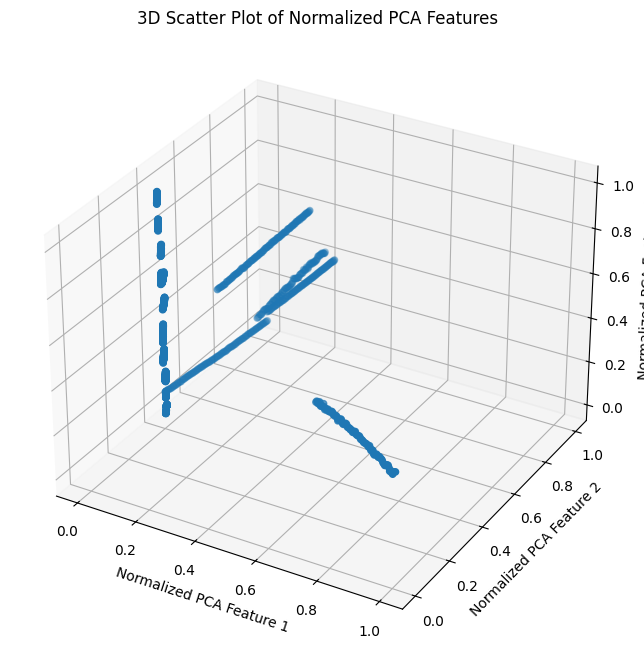

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_features_normalized_df['PCA_Feature_1_Normalized'],
           pca_features_normalized_df['PCA_Feature_2_Normalized'],
           pca_features_normalized_df['PCA_Feature_3_Normalized'])

ax.set_xlabel('Normalized PCA Feature 1')
ax.set_ylabel('Normalized PCA Feature 2')
ax.set_zlabel('Normalized PCA Feature 3')
ax.set_title('3D Scatter Plot of Normalized PCA Features')

plt.show()

Explained Variance Ratio for each component (Fault Developing): [0.83915569 0.1400828  0.02076151]
Total Explained Variance (Fault Developing): 0.9999999974749408

Normalized PCA Features DataFrame (Fault Developing):


,PCA_Feature_1_Normalized,PCA_Feature_2_Normalized,PCA_Feature_3_Normalized
0,0.030164,0.466883,3.289660
1,0.031252,0.469509,3.288851
2,0.031933,0.472367,3.291863
3,0.033028,0.474164,3.293035
4,0.033698,0.476126,3.296024


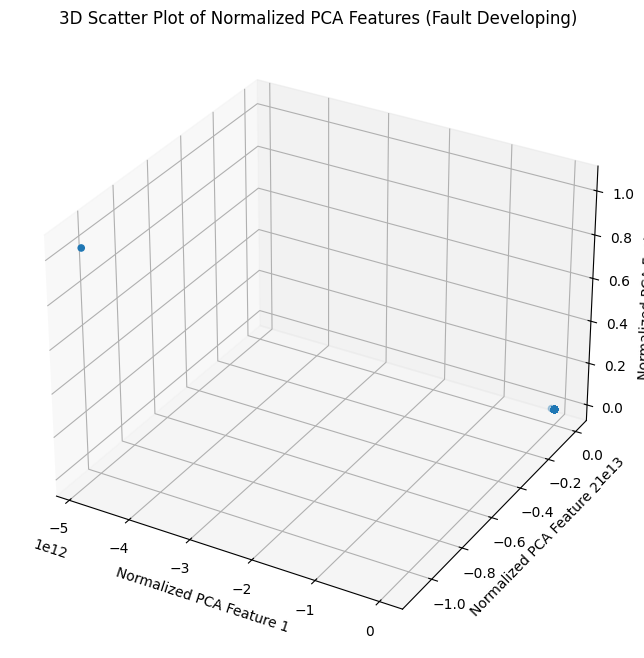

In [47]:
# Create empty dictionaries to store data for each sensor in fault developing data
fault_developing_sensor_data = {
    'Accelerometer': [],
    'Acoustic': [],
    'Temperature Difference': []
}

# Iterate through each window in fault developing data
for window in fault_developing_windows:
    # Extract data for each sensor and append to the respective list
    fault_developing_sensor_data['Accelerometer'].append(window['Accelerometer'].values)
    fault_developing_sensor_data['Acoustic'].append(window['Acoustic'].values)
    fault_developing_sensor_data['Temperature Difference'].append(window['Temperature Difference'].values)

# Calculate features for each sensor in fault developing data
accelerometer_features_fault_developing_df = calculate_features(fault_developing_sensor_data['Accelerometer'], 'Accelerometer')
acoustic_features_fault_developing_df = calculate_features(fault_developing_sensor_data['Acoustic'], 'Acoustic')
temperature_features_fault_developing_df = calculate_features(fault_developing_sensor_data['Temperature Difference'], 'Temperature')

# Merge the feature dataframes for fault developing data
merged_features_fault_developing_df = pd.concat([accelerometer_features_fault_developing_df, acoustic_features_fault_developing_df, temperature_features_fault_developing_df], axis=1)

# Initialize PCA with 4 components for fault developing data
pca_fault_developing = PCA(n_components=3)

# Fit PCA to the merged features and transform the data for fault developing data
pca_features_fault_developing = pca.transform(merged_features_fault_developing_df)

# Create a new DataFrame for the PCA features of fault developing data
pca_features_fault_developing_df = pd.DataFrame(pca_features_fault_developing, columns=[f'PCA_Feature_{i+1}' for i in range(3)])

# Drop the outlier row
pca_features_fault_developing_df = pca_features_fault_developing_df.drop(1544)


# Calculate the explained variance ratio for fault developing data
explained_variance_ratio_fault_developing = pca.explained_variance_ratio_

print("Explained Variance Ratio for each component (Fault Developing):", explained_variance_ratio_fault_developing)
print("Total Explained Variance (Fault Developing):", sum(explained_variance_ratio_fault_developing))

# Initialize the MinMaxScaler for fault developing data
scaler_pca_fault_developing = MinMaxScaler()

# Fit and transform the PCA features for fault developing data
pca_features_normalized_fault_developing = scaler_pca.transform(pca_features_fault_developing_df)

# Create a new DataFrame for the normalized PCA features of fault developing data
pca_features_normalized_fault_developing_df = pd.DataFrame(pca_features_normalized_fault_developing, columns=[f'PCA_Feature_{i+1}_Normalized' for i in range(pca_features_normalized_fault_developing.shape[1])])

# Display the first few rows of the normalized PCA features dataframe for fault developing data
print("\nNormalized PCA Features DataFrame (Fault Developing):")
display(pca_features_normalized_fault_developing_df.head())

# Create a 3D scatter plot for fault developing data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_features_normalized_fault_developing_df['PCA_Feature_1_Normalized'],
           pca_features_normalized_fault_developing_df['PCA_Feature_2_Normalized'],
           pca_features_normalized_fault_developing_df['PCA_Feature_3_Normalized'])

ax.set_xlabel('Normalized PCA Feature 1')
ax.set_ylabel('Normalized PCA Feature 2')
ax.set_zlabel('Normalized PCA Feature 3')
ax.set_title('3D Scatter Plot of Normalized PCA Features (Fault Developing)')

plt.show()

In [48]:
pca_features_normalized_fault_developing_df.shape

(1999, 3)

In [49]:
pca_features_normalized_df.shape

(2000, 3)

<Axes: >

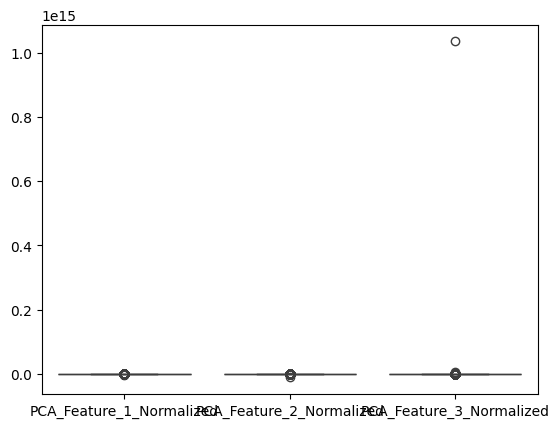

In [53]:
pca_features_normalized_fault_developing_df.describe()
sns.boxplot(data=pca_features_normalized_fault_developing_df)

In [51]:
# Calculate the IQR for each column in the fault developing PCA features dataframe
Q1 = pca_features_normalized_fault_developing_df.quantile(0.00001)
Q3 = pca_features_normalized_fault_developing_df.quantile(0.9995)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = pca_features_normalized_fault_developing_df[
    ((pca_features_normalized_fault_developing_df < lower_bound) | (pca_features_normalized_fault_developing_df > upper_bound)).any(axis=1)
]

# Print the row index of the outlier(s)
print("Row indices of outliers in Fault Developing PCA Features:")
print(outliers.index.tolist())

Row indices of outliers in Fault Developing PCA Features:
[1594]


<Axes: >

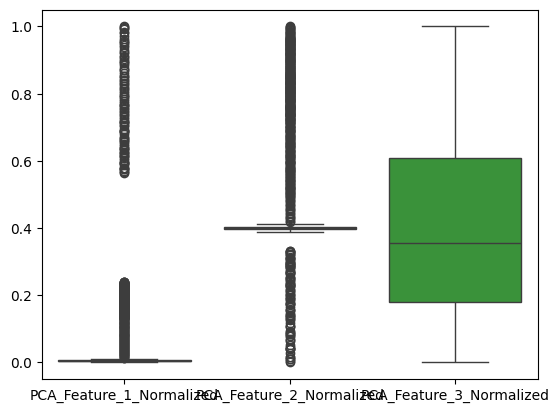

In [52]:
pca_features_normalized_df.describe()
sns.boxplot(data=pca_features_normalized_df)